# Validation of the Mixing Matrix with spatial variability

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from fgbuster.observation_helpers import get_instrument, standardize_instrument, get_observation
from micmac import *

In [2]:
# Choose and get instrument from public database
instr_name = 'SO_SAT'    # LiteBIRD  # SO_SAT
instr_ = get_instrument(instr_name)
instrument = standardize_instrument(instr_)

In [3]:
# General parameters (in a Gibbs sampling run coming from the parameter file)
NSIDE = 64
ncomp = 3
n_fgs_comp = 2
pos_special_freqs = np.array([0, -1])

In [4]:
instrument

namespace(frequency=array([ 27.,  39.,  93., 145., 225., 280.]),
          depth_i=array([35. , 21. ,  2.6,  3.3,  6.3, 16. ]),
          depth_p=array([49.5, 29.7,  3.7,  4.7,  8.9, 22.6]),
          fwhm=array([91., 63., 30., 17., 11.,  9.]))

In [5]:
# freq_inverse_noise = get_noise_covar(instrument.depth_p, NSIDE)
freq_inverse_noise = get_noise_covar_extended(instrument.depth_p, NSIDE)

### Spv configuration

In [6]:
# Num betas
n_betas = (ncomp-1)*(len(instrument.frequency)-ncomp+1)

In [7]:
# Read the spv configuration and print the spv tree
yaml_file_path = 'params_spv_SAT.yaml'   # ''  # 'params_spv_SAT.yaml'  # 'params_spv_LB.yaml'
root_tree = tree_spv_config(yaml_file_path, n_betas, n_fgs_comp, print_tree=True)

<_io.TextIOWrapper name='params_spv_SAT.yaml' mode='r' encoding='UTF-8'>
count_b: 8
n_betas:  8

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [1]
    f1
      default: [1]
      b0
        default: [1]
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f2
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [1]
    f1
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]
    f2
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]


In [8]:
# Get list of the nodes betas
nodes_b = get_nodes_b(root_tree)
print("List of all the betas (first all the ones for component 1 then all the ones for compoents 2):\n", nodes_b)

List of all the betas (first all the ones for component 1 then all the ones for compoents 2):
 [Node('/root/nside_spv/f1/b0'), Node('/root/nside_spv/f1/b1'), Node('/root/nside_spv/f1/b2'), Node('/root/nside_spv/f1/b3'), Node('/root/nside_spv/f2/b0'), Node('/root/nside_spv/f2/b1'), Node('/root/nside_spv/f2/b2'), Node('/root/nside_spv/f2/b3')]


### Initialization Mixing Matrix

In [9]:
initB = InitMixingMatrix(freqs=instrument.frequency, ncomp=ncomp, pos_special_freqs=pos_special_freqs, spv_nodes_b=nodes_b)
init_params = initB.init_params()
print("N params:", init_params.shape)
print("Params initial values (given in the order: all params for b1, all params for b2, ...):\n", init_params)


N params: (96,)
Params initial values (given in the order: all params for b1, all params for b2, ...):
 [0.33858815 0.33858815 0.33858815 0.33858815 0.33858815 0.33858815
 0.33858815 0.33858815 0.33858815 0.33858815 0.33858815 0.33858815
 0.02963068 0.02963068 0.02963068 0.02963068 0.02963068 0.02963068
 0.02963068 0.02963068 0.02963068 0.02963068 0.02963068 0.02963068
 0.00998213 0.00998213 0.00998213 0.00998213 0.00998213 0.00998213
 0.00998213 0.00998213 0.00998213 0.00998213 0.00998213 0.00998213
 0.00328725 0.00328725 0.00328725 0.00328725 0.00328725 0.00328725
 0.00328725 0.00328725 0.00328725 0.00328725 0.00328725 0.00328725
 0.00979233 0.00979233 0.00979233 0.00979233 0.00979233 0.00979233
 0.00979233 0.00979233 0.00979233 0.00979233 0.00979233 0.00979233
 0.05147511 0.05147511 0.05147511 0.05147511 0.05147511 0.05147511
 0.05147511 0.05147511 0.05147511 0.05147511 0.05147511 0.05147511
 0.12913911 0.12913911 0.12913911 0.12913911 0.12913911 0.12913911
 0.12913911 0.12913911 0.

### Mixing Matrix

Test preliminary functions

In [10]:
print(get_len_params(spv_nodes_b=nodes_b))

96


Test Mixing Matrix

In [11]:
B = MixingMatrix(instrument.frequency, ncomp, nodes_b, NSIDE, init_params, pos_special_freqs)

In [12]:
params = B.params

In [13]:
params_long = B.get_params_long(jax_use=True)
print(params_long.shape)
print(params_long)

(4, 2, 49152)
[[[0.33858815 0.33858815 0.33858815 ... 0.33858815 0.33858815 0.33858815]
  [0.00979233 0.00979233 0.00979233 ... 0.00979233 0.00979233 0.00979233]]

 [[0.02963068 0.02963068 0.02963068 ... 0.02963068 0.02963068 0.02963068]
  [0.05147511 0.05147511 0.05147511 ... 0.05147511 0.05147511 0.05147511]]

 [[0.00998213 0.00998213 0.00998213 ... 0.00998213 0.00998213 0.00998213]
  [0.12913911 0.12913911 0.12913911 ... 0.12913911 0.12913911 0.12913911]]

 [[0.00328725 0.00328725 0.00328725 ... 0.00328725 0.00328725 0.00328725]
  [0.44076761 0.44076761 0.44076761 ... 0.44076761 0.44076761 0.44076761]]]


In [14]:
B.get_B()[:,:,0]

array([[1.        , 1.        , 0.        ],
       [1.        , 0.33858815, 0.00979233],
       [1.        , 0.02963068, 0.05147511],
       [1.        , 0.00998213, 0.12913911],
       [1.        , 0.00328725, 0.44076761],
       [1.        , 0.        , 1.        ]])

# $B^t N^{-1} B$

In [15]:
invBtinvNB = get_inv_BtinvNB(freq_inverse_noise, B.get_B(), jax_use=True)

In [16]:
invBtinvNB.shape

(3, 3, 49152)

In [17]:
invBtinvNB[:,:,0]

Array([[ 0.00499825, -0.02362731, -0.01513969],
       [-0.02362731,  0.66329745,  0.0518234 ],
       [-0.01513969,  0.0518234 ,  0.108322  ]], dtype=float64)

In [18]:
nstokes = 2

In [19]:
model = "d0s0c1"
np.random.seed(0)
input_freq_maps = get_observation(instrument, model, nside=NSIDE, noise=False)[:,1:,:]
np.random.seed(0)
cmb_maps = get_observation(instrument, "c1", nside=NSIDE, noise=False)[0,1:,:]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
mixing_matrix_sampled = B.get_B()

In [21]:
s_cML = get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=True)[0]

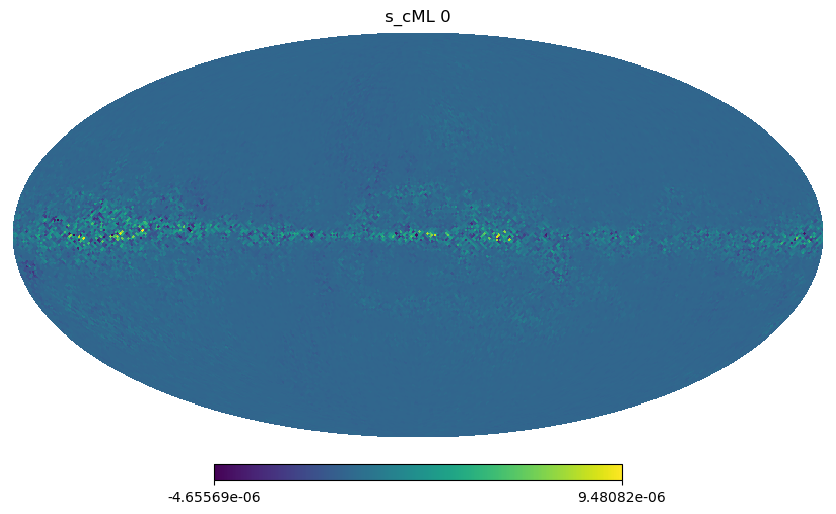

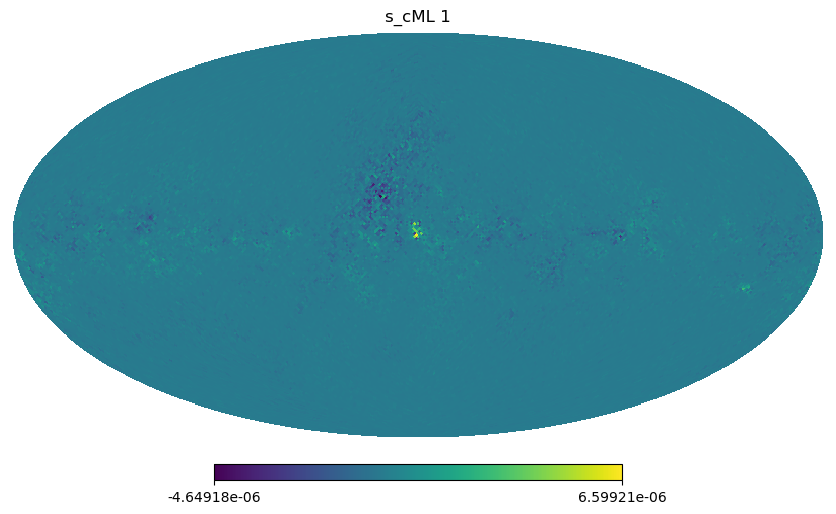

In [22]:
for i in range(nstokes):
    hp.mollview(s_cML[i]-cmb_maps[i], title="s_cML "+str(i))
    plt.show()